<a href="https://colab.research.google.com/github/marcinwolter/DeepLearning_2020/blob/main/shooting_MDN_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Zadanie:

Strzelanie z armaty. 
Wejście: obrazek 64x64 piksele pokazujący kierunke lufy działa. 
Wyjście: miejsce trafienia. Jest ono rozmyte funkcją Gaussa.

Na obecnym etapie sieć konwolucyjna znajduje na podstawie rysunku kierunek strzału i przewiduje najbardziej prawdopodobny punkt trafienia. 

Zadanie:
1. Za pomocą sieci MDN znaleźć rozkład prawdopodobieństwa trafienia.
2. Narysować taki rozkład dla zmieniających się położen lufy
3. Narysować taki rozkład dla określonego położenia lufy armaty.
4. Narysować rozkłady średnich i szerokości rozkładów Gaussa służących do aproksymacji rozkładu prawdopodobieństwa.
5. Powtóryć analizę dla rozkładu prawdopodobieństwa trafienia będącego dwoma rozsuniętymi rozkładami gaussa:

```
  # Here the two-gaussian distribution is produced
  rand1 = np.random.normal(loc=  1, scale=scale, size=half_sample)
  rand2 = np.random.normal(loc= -1, scale=scale, size=NSAMPLE-half_sample)
  random = np.concatenate((rand1,rand2), axis=0)
  y_data = tan_angle*length + random
```




# Shoot the cannon

The position of the cannon is decoded from the 64x64 pixel image (convolutional network should be used). The cannon shoots and the hit point is smeared by some not neceserily gaussian probability (could be two gaussians with different means).
The task is to design the MDN network to find the probability of the hit position.


# Mixture Density Network

Reproducing the classic Bishop MDN network tasks in Keras. The idea in this task is to predict a the value of an inverse sine function. This function has multiple real-valued solutions at each point, so the ANN model needs to have the capacity to handle this in it's loss function. An MDN is a good way to handle the predictions of these multiple output values.

There's a couple of other versions of this task, and this implementation owes much to the following:

- [David Ha - Mixture Density Networks with TensorFlow](http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/)
- [Mixture Density Networks in Edward](http://edwardlib.org/tutorials/mixture-density-network)

In [1]:
# Install mdn
# !pip install keras-mdn-layer


from tensorflow.compat.v1 import keras
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

# import mdn
 
import numpy as np
import random
import matplotlib.pyplot as plt


## Generate Synthetic Data

Data generation

In [2]:
PLOT_WIDTH = 64
PLOT_DIM = (PLOT_WIDTH,PLOT_WIDTH)
MAX_ANGLE = 0.4

def generate_data(NSAMPLE=3000, scale=1., rotation_range=0.3, rotation=0):
# NSAMPLE - number of shoots
# scale - smearing of each gaussian
# rotation-range - cannon can rotate in this range
# rotation - center of the rotation range

  # shooting angle
  tan_angle = np.float32(np.random.uniform(rotation - rotation_range, rotation + rotation_range, NSAMPLE))
  

  # target shooting
  length = 30.
  
  half_sample = int(NSAMPLE/2)

  # Here the two-gaussian distribution is produced 
  # here we can produce two-gaussians distribution
  rand1 = np.random.normal(loc=  0, scale=scale, size=half_sample)
  rand2 = np.random.normal(loc=  0, scale=scale, size=NSAMPLE-half_sample)
  random = np.concatenate((rand1,rand2), axis=0)
  y_data = tan_angle*length + random


  # generate events
  x_data=np.zeros((NSAMPLE,PLOT_DIM[0],PLOT_DIM[1],1))

  x = np.arange(start=0, stop=PLOT_WIDTH, step=1.)
  y = npy = tan_angle * x[ :, np.newaxis]+PLOT_WIDTH/2

  for i in range(NSAMPLE):
    for j in range(2,PLOT_WIDTH-2):
      x_data[i,int(y[j,i]),j] = 1.

  # normalize y_data
  y_data = y_data/(MAX_ANGLE*length)
  x_data = x_data.reshape(NSAMPLE,PLOT_WIDTH,PLOT_WIDTH,1)

  # plot the generated distribution
  #plt.hist(y_data, density=True, bins=30,  alpha=0.5, label='train data') 
  #plt.show()

  return x_data, y_data



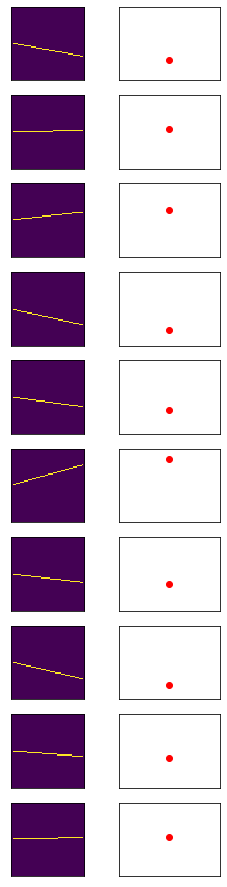

In [3]:
## Generating some data:
NSAMPLE = 10000
SCALE = 0.1

x_data, y_data = generate_data(NSAMPLE=NSAMPLE, scale=SCALE, rotation_range=0.3)

fig = plt.figure(figsize=(4, 16))

# plot first ten events
for n in range(10):
  ax = fig.add_subplot(10, 2, 2*n + 1, xticks=[], yticks=[])
  ax.imshow(x_data[n].reshape(PLOT_WIDTH,PLOT_WIDTH), interpolation='nearest')
  ax = fig.add_subplot(10, 2, 2*n + 2, xticks=[], yticks=[])
  ax.plot([0],[-y_data[n]], 'ro',)
  plt.ylim([-1, 1])
  plt.xlim([-1, 1])

plt.show()


## Build the MDN Model

Now we will construct the MDN model in Keras. This uses the `Sequential` model interface in Keras.

The `MDN` layer comes after one or more `Dense` layers. You need to define the output dimension and number of mixtures for the MDN like so: `MDN(output_dimension, number_mixtures)`.



For MDNs, we have to use a special loss function that can handle the mixture parameters: the function has to take into account the number of output dimensions and mixtures.

In [4]:
N_HIDDEN = 32
N_MIXES = 2  #5

print(x_data.shape)

model = keras.Sequential()

# convolutional network
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(PLOT_WIDTH,PLOT_WIDTH,1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))

'''
# fully connected network
model.add(Flatten(batch_input_shape=(None, PLOT_WIDTH*PLOT_WIDTH,1)) )
model.add(Dense(N_HIDDEN, activation='relu'))
model.add(Dense(N_HIDDEN, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(N_HIDDEN, activation='relu'))
model.add(Dense(N_HIDDEN, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(N_HIDDEN, activation='relu'))
'''
# last layer with single node to return the hit position
model.add(keras.layers.Dense(1))


# RMSprop() optimizer is used (adam was slightly unstable)
# Dla MDN można użyć i potem rysować  metrics=[mdn.get_mixture_mse_accuracy(1,N_MIXES)]
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.RMSprop() )
model.summary()

(10000, 64, 64, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1

### Training the model

Now we train the model using Keras' normal `fit` command.

In [5]:
# Dla MDN liczba epochs powinna być większa, np. 100
history = model.fit(x=x_data, y=y_data, batch_size=128, epochs=20, validation_split=0.2)

Epoch 1/20
63/63 [==============================] - 7s 52ms/step - loss: 0.0623 - val_loss: 0.0071
Epoch 2/20
63/63 [==============================] - 3s 42ms/step - loss: 0.0092 - val_loss: 0.0173
Epoch 3/20
63/63 [==============================] - 3s 42ms/step - loss: 0.0061 - val_loss: 0.0042
Epoch 4/20
63/63 [==============================] - 3s 41ms/step - loss: 0.0039 - val_loss: 0.0035
Epoch 5/20
63/63 [==============================] - 3s 43ms/step - loss: 0.0029 - val_loss: 0.0011
Epoch 6/20
63/63 [==============================] - 3s 41ms/step - loss: 0.0025 - val_loss: 0.0011
Epoch 7/20
63/63 [==============================] - 3s 42ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 8/20
63/63 [==============================] - 3s 42ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 9/20
63/63 [==============================] - 3s 42ms/step - loss: 0.0016 - val_loss: 0.0027
Epoch 10/20
63/63 [==============================] - 3s 42ms/step - loss: 0.0013 - val_loss: 6.4159e-04
Epoch

### Training and Validation Loss

It's interesting to see how the model trained. We can see that after a certain point training is rather slow.



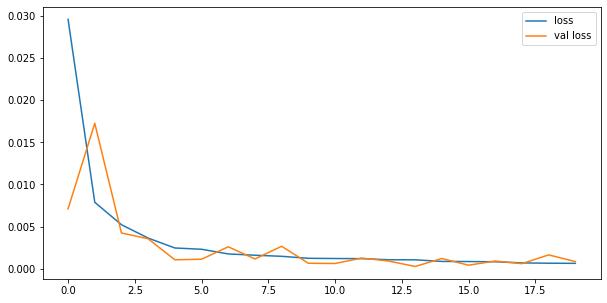

In [6]:
plt.figure(figsize=(10, 5))
#plt.ylim([0,0.02])
plt.plot(history.history['loss'], label='loss' )
plt.plot(history.history['val_loss'], label='val loss' )
plt.legend(loc='upper right')
plt.show()

## Sampling Functions

The MDN model outputs parameters of a mixture model---a list of means (mu), variances (sigma), and weights (pi).

The `mdn` module provides a function to sample from these parameters as follows. First the parameters are split up into `mu`s, `sigma`s and `pi`s, then the categorical distribution formed by the `pi`s is sampled to choose which mixture component should be sampled, then that component's `mu`s and `sigma`s is used to sample from a multivariate normal model, here's the code:

    def sample_from_output(params, output_dim, num_mixes, temp=1.0):
        """Sample from an MDN output with temperature adjustment."""
        mus = params[:num_mixes*output_dim]
        sigs = params[num_mixes*output_dim:2*num_mixes*output_dim]
        pis = softmax(params[-num_mixes:], t=temp)
        m = sample_from_categorical(pis)
        # Alternative way to sample from categorical:
        # m = np.random.choice(range(len(pis)), p=pis)
        mus_vector = mus[m*output_dim:(m+1)*output_dim]
        sig_vector = sigs[m*output_dim:(m+1)*output_dim] * temp  # adjust for temperature
        cov_matrix = np.identity(output_dim) * sig_vector
        sample = np.random.multivariate_normal(mus_vector, cov_matrix, 1)
        return sample
        
If you only have one prediction to sample from, you can use the function as is; but if you need to sample from a lot of predictions at once (as in the following sections), you can use `np.apply_along_axis` to apply it to a whole numpy array of predicted parameters.

## Try out the MDN Model

Now we try out the model by making predictions for some data points

We're going to sample from these parameters for each point, and also try plotting the parameters themselves so we can have some insight into what the model is learning!

In [11]:
# generate test data

# the whole range of data (identical with the training sample)
x_test, y_test = generate_data(NSAMPLE=NSAMPLE, scale=SCALE, rotation_range=0.3, rotation = 0.0)
# just one shooting position
#x_test, y_test = generate_data(NSAMPLE=NSAMPLE, scale=SCALE, rotation_range=0.01, rotation = 0.2)

In [12]:
## Sample on some test data:


# Make predictions from the model
y_pred = model.predict(x_test)
# y_test contains parameters for distributions, not actual points on the graph.
# To find points on the graph, we need to sample from each distribution.


In [13]:

# Tu można narysować rozkłady parametrów rozkładów Gaussa użytych do aproksymacji prawdopodobieństwa



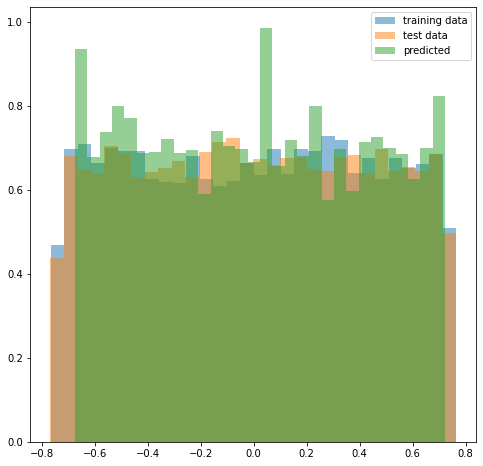

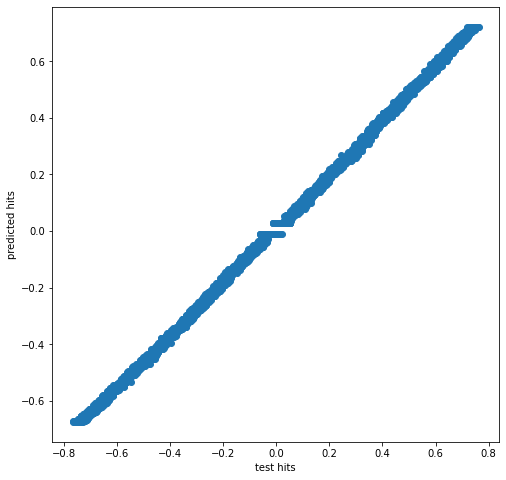

In [14]:

# Plot the samples
plt.figure(figsize=(8, 8))
plt.hist(y_data.reshape(NSAMPLE,1), density=True, bins=30,  alpha=0.5, label='training data') 
plt.hist(y_test.reshape(NSAMPLE,1), density=True, bins=30,  alpha=0.5, label='test data')
plt.hist(y_pred, density=True, bins=30,  alpha=0.5, label='predicted')
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(8, 8))
plt.scatter(y_test,y_pred)
plt.xlabel("test hits")
plt.ylabel("predicted hits")

plt.show()